## HUD Volume Estimation

In [1]:
import numpy as np

In [2]:
def ScaledDiffuserScreenWidth(inputs):
    ScalingFactor = inputs["FullHorizontalFOV"]/10
    return inputs["HUD_SCREEN_10x5_FOV_BASELINE_WIDTH"] * ScalingFactor


## Calculations
### Mirror Size Calculations

##### Mirror 1
def RaySlopeH_m(inputs):
    return (np.tan(np.radians(inputs["FullHorizontalFOV"]/2))*inputs["VirtualImageDistance"]-inputs["EyeboxFullWidth"]/2)/(-inputs["VirtualImageDistance"])
    
def InterceptH(inputs):
    return inputs["EyeboxFullWidth"]/2

def Mirror1Horizontal(inputs):
    points = {
        "Mirror1TopPointXH" : -inputs["EyeboxToMirror1"],
        "Mirror1TopPointYH" : RaySlopeH_m(inputs) * (-inputs["EyeboxToMirror1"]) + InterceptH(inputs),
        "Mirror1BottomPointXH" : -inputs["EyeboxToMirror1"],
        "Mirror1BottomPointYH" : -RaySlopeH_m(inputs) * (-inputs["EyeboxToMirror1"]) + InterceptH(inputs)
    }
    return points

def RaySlopeV_m(inputs):
    return (np.tan(np.radians(inputs["FullVerticalFOV"]/2))*inputs["VirtualImageDistance"]-inputs["EyeboxFullHeight"]/2)/(-inputs["VirtualImageDistance"])

def InterceptV(inputs):
    return inputs["EyeboxFullHeight"]/2

def MirrorFullHeight(inputs):
    #TiltAngleOfM1 = Mirror1ObliquityAngle #degrees
    TopPointX    = ( -InterceptV(inputs) * np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) - inputs["EyeboxToMirror1"]) / (1+np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) * RaySlopeV_m(inputs))
    BottomPointX = (  InterceptV(inputs) * np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) - inputs["EyeboxToMirror1"]) / (1-np.tan(np.radians(inputs["Mirror1ObliquityAngle"])) * RaySlopeV_m(inputs))

    TopPointY    = (  RaySlopeV_m(inputs) * TopPointX    ) + InterceptV(inputs)
    BottomPointY = ( -RaySlopeV_m(inputs) * BottomPointX ) - InterceptV(inputs)

    return np.sqrt(np.power(TopPointX-BottomPointX,2)+np.power(TopPointY-BottomPointY,2))

#### M1 focal length calculation
def M1ToVirtualImage(inputs):
    return inputs["VirtualImageDistance"]-inputs["EyeboxToMirror1"] #(s2) mm

def SceenToM1(inputs):
    ## Screen and Image Calculations		
    VirtualImageWidth = np.tan(np.radians(inputs["FullHorizontalFOV"]/2))*inputs["VirtualImageDistance"]*2 #mm
    HUDImageMagnification = VirtualImageWidth/ScaledDiffuserScreenWidth(inputs)	#x
    return M1ToVirtualImage(inputs)/HUDImageMagnification #mm


### HUD Volume Calculation
def VolumeBetweenScreenAndM1Liters(inputs):
    ## Primary mirror size estimate
    Mirror1HorizontalDiameterEstimate = Mirror1Horizontal(inputs)["Mirror1TopPointYH"]*2 #mm
    Mirror1VerticalDiameterEstimate = MirrorFullHeight(inputs) #mm

    Mirror1Width = Mirror1HorizontalDiameterEstimate #mm
    Mirror1Height = Mirror1VerticalDiameterEstimate #mm
    Mirror1Area = Mirror1Width*Mirror1Height #mm^2
            
    ScreenToM1 = SceenToM1(inputs) #mm
    ScreenWidth = ScaledDiffuserScreenWidth(inputs) #mm
    ScreenHeight = (inputs["FullVerticalFOV"]/inputs["FullHorizontalFOV"])*ScaledDiffuserScreenWidth(inputs) #mm
            
    # Find height of pyramid from base		
    HalfDiagonalM1 = 0.5*(np.sqrt(np.power(Mirror1Width,2)+np.power(Mirror1Height,2))) #Y2
    HalfDiagonalScreen = 0.5*(np.sqrt(np.power(ScreenWidth,2)+np.power(ScreenHeight,2))) #Y1
    Slope = (HalfDiagonalScreen-HalfDiagonalM1)/ScreenToM1 #(m)
    #x=0, y=0, so b=0		
    X2 = HalfDiagonalM1/Slope
    X1 = HalfDiagonalScreen/Slope
    ApexFromMirror1 = np.absolute(X2)
    ApexFromScreen = np.absolute(X1)

    # Find Mirror to screen volume
    AreaPyramidFromMirror = (1/3)*Mirror1Width*Mirror1Height*ApexFromMirror1 #mm^3
    AreaPyramidFromScreen = (1/3)*ScreenWidth*ScreenHeight*ApexFromScreen #mm^3
    VolumeBetweenScreenAndM1 = AreaPyramidFromMirror-AreaPyramidFromScreen #mm^3

    return 0.000001*VolumeBetweenScreenAndM1

## Outputs
### HUD Volume Estimate
def TotalMechanicalVolumeOfHUD(inputs):
    ## Primary mirror size estimate
    Mirror1HorizontalDiameterEstimate = Mirror1Horizontal(inputs)["Mirror1TopPointYH"]*2 #mm
    Mirror1VerticalDiameterEstimate = MirrorFullHeight(inputs) #mm

    VolumeFromHUDmirrors = VolumeBetweenScreenAndM1Liters(inputs)*(1-inputs["M1M2OverlapFraction"]/100) #Liters
    #print("Volume from HUD mirrors: {:.2f} liters".format(VolumeFromHUDmirrors))
    VolumeFromMirrorsAndPGU = VolumeFromHUDmirrors+inputs["PGUVolumeEstimate"] #Liters
    #print("Volume from mirrors + PGU: {:.2f} liters".format(VolumeFromMirrorsAndPGU))
    total = VolumeFromMirrorsAndPGU*(1+inputs["MechanicalVolumeIncrease"]/100)
    #print("Total Mechanical Volume of HUD: {:.2f} liters".format(total))
    return total


In [3]:
inputs = {
    "FullHorizontalFOV" : 10,
    "FullVerticalFOV" : 4,
    "VirtualImageDistance" : 15000,
    "EyeboxToMirror1" : 1000,
    "EyeboxFullWidth" : 140,
    "EyeboxFullHeight" : 60,
    "Mirror1ObliquityAngle" : 30,
    "HUD_SCREEN_10x5_FOV_BASELINE_WIDTH" : 70,
    "MechanicalVolumeIncrease" : 40,
    "M1M2OverlapFraction" : 0,
    "PGUVolumeEstimate" : 0.5
}

TotalMechanicalVolumeOfHUD(inputs)

10.562354834597118

## Surplus Value

In [4]:
import math
import simpy
import simpy.util
import settings as s

In [5]:
# Input variables

# FullHorizontalFOV = 10
# FullVerticalFOV = 4
# mirrorSize = 200
# volume = 4
# expectedPerformance = 10
# unitCost = 0.001
# cost_redesign = 0.005

# Calculate engineering variables

## calculate % FoV

def calculate_fov(FullHorizontalFOV,FullVerticalFOV):
    """calculate a metric for the FOV of the HUD"""
    FoV = (FullHorizontalFOV * FullVerticalFOV * 100) / (67 * 20)
    return FoV

## cost model

def calculate_cost_vehicle(cost_mirror_unit, mirrorSize, cost_vehicle_without_HUD, cost_assembly, cost_redesign):
    """calculate the cost of the vehicle"""
    cost_mirror = cost_mirror_unit * mirrorSize
    cost_vehicle = cost_mirror + cost_vehicle_without_HUD + cost_assembly + cost_redesign # euro
    return cost_vehicle

## weight model

def calculate_weight_vehicle(volume, weight_vehicle_without_HUD):
    """calculate the weight of the vehicle"""       
    weight_hud = 0.1 * volume  # kg
    weight_vehicle = weight_hud + weight_vehicle_without_HUD # kg
    return weight_vehicle

## fuel consumption model

def calculate_fuel_consumption(volume, weight_vehicle_without_HUD):
    """calculate the fuel consumption of the vehicle"""
    fuel_consumpt = calculate_weight_vehicle(volume, weight_vehicle_without_HUD) * math.exp(-4.7)  # km / liter
    return fuel_consumpt

def calculate_fuel_cost(volume, weight_vehicle_without_HUD, kilometers_year, cost_fuel):
    """calculate the fuel cost of the vehicle"""
    fuel_consumpt = calculate_fuel_consumption(volume, weight_vehicle_without_HUD)
    fuel_cost_year = (kilometers_year/fuel_consumpt) * cost_fuel # keuro / year
    return fuel_cost_year

## calculate demand, copied from demand.py

def calculate_demand(FullHorizontalFOV, FullVerticalFOV, volume, weight_vehicle_without_HUD, cost_fuel, person_height, price_vehicle, year):
    """calculate the demand of the vehicle"""
    Lin_no__1 = (400.389457364428
                + -0.0496637629531165    * (calculate_fov(FullHorizontalFOV, FullVerticalFOV))
                +  0.0438458326033747    * (calculate_fuel_consumption(volume, weight_vehicle_without_HUD))
                +  3.53646955685314      * (cost_fuel * 1000)
                + -0.0958055046356103    * (person_height)
                +  0.0000987106990985412 * (price_vehicle * 1000)
                + -0.193495221339535     * (year)
                )
    Prob_yes_1 = 1 / (1 + math.exp(Lin_no__1)) # demand
    return Prob_yes_1


# create class for Surplus Value Model

class SV:

    # configuration

    price_vehicle = 35000 / 1000 # k€uro/vehicle
    cost_assembly = 556.20 / 1000 # k€euro/vehicle
    cost_vehicle_without_HUD = 20000 / 1000  # k€uro /vehicle
    weight_vehicle_without_HUD = 1800 # kg /vehicle
    cost_fuel = 1.9 / 1000 # kEuro / liter
    kilometers_year = 10000 # km/year
    market_window = 10 # years
    sales_distr = [0.2, 0.4, 0.8, 1, 1, 1, 1, 1, 0.8, 0.4, 0.2]
    theoretical_demand = 70000 # vehicles/year
    operation_time = 10 # years
    development_time = 0 # years
    production_time = 0.1 # years
    sales_time = 0.1 # years
    year = 2035 #year
    person_height = 180 # cm

    # Redesign costs
    #cost_redesign = 1000 # k€ / liter

    # configuration of simulation

    discrete_time = 0.01
    discount_rate = 0.08
    simulation_duration = 30 # years
    time_between_counting = 1 # year

    def __init__(self, env, FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign):

        self.env = env

        self.FullHorizontalFOV = FullHorizontalFOV
        self.FullVerticalFOV = FullVerticalFOV
        self.mirrorSize = mirrorSize
        self.volume = volume
        self.expectedPerformance = expectedPerformance #HFoV*VFoV
        self.cost_mirror_unit = unitCost # k€/mm
        self.cost_redesign = cost_redesign # k€/l

        self.i = 0

        # initializing costs and revenues

        self.development_cost = 0
        self.production_cost = 0
        self.integration_cost = 0
        self.operation_cost = 0

        self.total_development_cost = 0
        self.total_production_cost = 0
        self.total_operation_cost = 0
        self.total_revenue = 0
        self.total_cost = 0

        self.cost = 0
        self.revenue = 0
        self.net_revenue = - self.cost
        self.NPV = self.net_revenue / (1 + self.discount_rate) ** env.now
        self.cumulativeNPV = self.NPV

        # initializing data for plot
        self.obs_time = [env.now]
        self.cashflow_level = [self.cumulativeNPV]

        # initializing counters for the different phases

        self.total_demand = 0
        self.in_development = 0
        self.in_production = 0
        self.in_sale = 0
        self.total_produced = 0
        self.in_operation = 0
        self.EoL = 0

        # start the business process every time an option is defined, start the development,
        # if development time != 0, start the market delayed, else start instantaneously

        # self.action = start_delayed(env, self.market(market_window, time_between_counting), self.development_time)

        self.action = env.process(self.lifecycle())

        self.action = env.process(self.observe())

        self.action = env.process(self.calculate())

    def lifecycle(self):

        self.in_development = 1

        yield self.env.timeout(self.development_time)

        self.in_development = 0

        self.action = self.env.process(self.market())

    def market(self):

        while self.env.now < self.market_window:

            self.action = self.env.process(self.business_run())

            yield self.env.timeout(self.time_between_counting)

            self.i += 1

    def business_run(self):

        # set vehicle demand

        self.current = math.ceil(s.theoretical_demand 
                                * calculate_demand(self.FullHorizontalFOV, 
                                                  self.FullVerticalFOV, 
                                                  self.volume, 
                                                  self.weight_vehicle_without_HUD, 
                                                  self.cost_fuel, 
                                                  self.person_height, 
                                                  self.price_vehicle, 
                                                  self.year)
                                * s.sales_distr[self.i])   # calculation of current demand

        # set vehicles in production

        self.in_production += self.current

        yield self.env.timeout(s.production_time)

        # after production_time, vehicles are in sale

        self.in_production -= self.current

        self.in_sale += self.current

        yield self.env.timeout(s.sales_time)

        # after sales time, set vehicles in use

        self.in_sale -= self.current

        self.in_operation += self.current

        yield self.env.timeout(s.operation_time)

        # after operation time, set vehicles out of life

        self.in_operation -= self.current

        self.EoL += self.current

    def observe(self):
        while True:

            self.obs_time.append(self.env.now)
            self.cashflow_level.append(self.cumulativeNPV)

            #print (self.revenue)

            #if self.cumulativeNPV < 0:
                #self.payback_period = env.now

            yield self.env.timeout(s.discrete_time)

    def calculate(self):
        """function for cost, revenue and NPV calculations"""

        while True:
            # all calculations are scaled down by the discrete time

            self.production_cost = (self.in_production
                                   * (calculate_cost_vehicle(self.cost_mirror_unit, 
                                                           self.mirrorSize, 
                                                           self.cost_vehicle_without_HUD, 
                                                           self.cost_assembly,
                                                           self.cost_redesign))
                                   * s.discrete_time)  # the total cost is "spread" along the production time

            self.revenue = self.in_sale * (s.price_vehicle) * s.discrete_time

            #self.operation_cost = self.in_operation * ((kilometers_year/fuel_consumpt) * cost_fuel) * discrete_time

            self.total_revenue += self.revenue

            # sum of cost and revenue and caluclation of NPV
            self.cost = self.production_cost #+ self.operation_cost
            self.total_cost -= self.cost
            self.net_revenue = self.revenue - self.cost
            self.NPV = self.net_revenue / (1 + s.discount_rate) ** self.env.now
            self.cumulativeNPV += self.NPV

            yield self.env.timeout(s.discrete_time)



# run Surplus Value of alternative
# launch environment

def surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign):

    env = simpy.Environment()
    #simpy.util.start_delayed(env, simulation_run(env), delay=1)
    hud = SV(env, FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign)
    #print("Starting simulation.")
    env.run(until=s.simulation_duration)
    #print("End of simulation.")

    surplus_value = hud.cumulativeNPV/1000 # converted in million euro
    lifecycle_costs = -hud.total_cost/1000

    #print(surplus_value)
    return surplus_value, lifecycle_costs



In [6]:
FullHorizontalFOV = 1
FullVerticalFOV = 1
mirrorSize = 1
volume = 1
expectedPerformance = 1
unitCost = 1
cost_redesign = 1

surplus_value(FullHorizontalFOV, FullVerticalFOV, mirrorSize, volume, expectedPerformance, unitCost, cost_redesign)

(188.3885603932704, 524.9623973859993)

## Value Weighted Filtered Outdegree

From:
Viscito, L. and Ross, A.M. (2009), “Quantifying Flexibility in Tradespace Exploration: Value Weighted Filtered Outdegree”, AIAA Space 2009 Conference and Exposition, pp. 14–17.

In [7]:
from doepy import build
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# N is the number of designs considered
N = 100
# k is the current epoch (k+1) is the next epoch in the era
k = 1
# i is the design under consideration
i = 1
# j is the destination design
j = 2
# u_i^{k+1} is the utility of the design under consideration (i) in the k+1 epoch
# u_j^{k+1} is the utility of the design j in the k+1 epoch
# Arc_{i,j}^{k} is the transition matrix with local value indicating an arc from design i to design j in the k epoch

sign = lambda x: -1 if x < 0 else (1 if x > 0 else 0)

def u(i,k):
    utility = i*k
    return utility

def Arc(i,j,k):
    arc = 1
    return arc

def VWFO(i,k):
    epsilon = 0
    for j in range(1,N-1,1):
        epsilon = epsilon + sign(u(j,k+1)-u(i,k+1)) * Arc(i,j,k)
    vwfo = 1 / (N-1)
    return vwfo

print(VWFO(i,k))

0.010101010101010102


In [9]:
class design:
    def __init__(self, platform, technology, t_x1, t_x2, t_x3):
        self.technology = technology
        self.platform = platform
        self.t_x1 = t_x1
        self.t_x2 = t_x2
        self.t_x3 = t_x3
        if technology == 1:
            self.volume = t_x1 * t_x2 * np.sqrt(t_x3) / 500
            self.x = np.cbrt(self.volume / (1 + 3 + 1)) * 100 # in mm
            self.y = 3 * self.x
            self.z = 1 * self.x
            self.utility = t_x1 * t_x2 * t_x3
            self.value, self.cost = surplus_value(FullHorizontalFOV=self.t_x1, FullVerticalFOV=self.t_x2, mirrorSize=100, volume=self.volume, expectedPerformance=100, unitCost=100, cost_redesign=100)
        elif technology == 2:
            self.volume = t_x1 * t_x2 * np.sqrt(t_x3) / 500
            self.x = np.cbrt(self.volume / (1 + 3 + 2)) * 100 # in mm
            self.y = 3 * self.x
            self.z = 2 * self.x
            self.utility = t_x1 * t_x2 * t_x3
            self.value, self.cost = surplus_value(FullHorizontalFOV=self.t_x1, FullVerticalFOV=self.t_x2, mirrorSize=100, volume=self.volume, expectedPerformance=100, unitCost=100, cost_redesign=100)
        elif technology == 3:
            self.volume = np.sqrt(t_x1 * t_x2 * np.sqrt(t_x3)) / 20
            self.x = np.cbrt(self.volume / (1 + 3 + 0.5)) * 100 # in mm
            self.y = 3 * self.x
            self.z = 0.5 * self.x
            self.utility = np.sqrt(self.volume) * t_x3 * 10
            self.value, self.cost = surplus_value(FullHorizontalFOV=self.t_x1, FullVerticalFOV=self.t_x2, mirrorSize=100, volume=self.volume, expectedPerformance=100, unitCost=100, cost_redesign=100)

class platform:
    def __init__(self, id, p_x1, p_x2, p_x3):
        self.id = id
        self.p_x1 = p_x1
        self.p_x2 = p_x2
        self.p_x3 = p_x3
        self.volume_available = p_x1 * p_x2 * p_x3

class technology:
    def __init__(self, id, name, volume_coeficients, factors):
        self.id = id
        self.name = name
        self.volume_coeficients = volume_coeficients
        self.factors = factors

class epoch:
    def __init__(self, id, duration, description, s_x1, s_x2, s_x3):
        self.id = id
        self.duration = duration
        self.description = description
        self.s_x1 = s_x1
        self.s_x2 = s_x2
        self.s_x3 = s_x3


In [10]:
def calculate_tradespace(factors, num_samples, platform, technology):

    lhs = build.space_filling_lhs(factors, num_samples=num_samples)

    designs = []
    for index, row in lhs.iterrows():
        design_t = design(platform, technology,row['t_x1'],row['t_x2'],row['t_x3'])
        designs.append(design_t)
        #print(f"Design {index} \n x = {design_t.x}\t{platform.p_x1} \n y = {design_t.y}\t{platform.p_x2} \n z = {design_t.z}\t{platform.p_x3}")

    x_in =  [y.volume  for y in designs if (y.x <= platform.p_x1) and (y.y <= platform.p_x2) and (y.z <= platform.p_x3)]
    y_in =  [y.utility for y in designs if (y.x <= platform.p_x1) and (y.y <= platform.p_x2) and (y.z <= platform.p_x3)]
    x_out = [y.volume  for y in designs if (y.x >  platform.p_x1) or  (y.y >  platform.p_x2) or  (y.z >  platform.p_x3)]
    y_out = [y.utility for y in designs if (y.x >  platform.p_x1) or  (y.y >  platform.p_x2) or  (y.z >  platform.p_x3)]

    return x_in, y_in, x_out, y_out

In [11]:
def calculate_tradespace_value_cost(factors, num_samples, platform, technology):

    lhs = build.space_filling_lhs(factors, num_samples=num_samples)

    designs = []
    for index, row in lhs.iterrows():
        design_t = design(platform, technology,row['t_x1'],row['t_x2'],row['t_x3'])
        designs.append(design_t)
        #print(f"Design {index} \n x = {design_t.x}\t{platform.p_x1} \n y = {design_t.y}\t{platform.p_x2} \n z = {design_t.z}\t{platform.p_x3}")

    x_in =  [y.cost  for y in designs if (y.x <= platform.p_x1) and (y.y <= platform.p_x2) and (y.z <= platform.p_x3)]
    y_in =  [-y.value for y in designs if (y.x <= platform.p_x1) and (y.y <= platform.p_x2) and (y.z <= platform.p_x3)]
    x_out = [y.cost  for y in designs if (y.x >  platform.p_x1) or  (y.y >  platform.p_x2) or  (y.z >  platform.p_x3)]
    y_out = [-y.value for y in designs if (y.x >  platform.p_x1) or  (y.y >  platform.p_x2) or  (y.z >  platform.p_x3)]

    return x_in, y_in, x_out, y_out

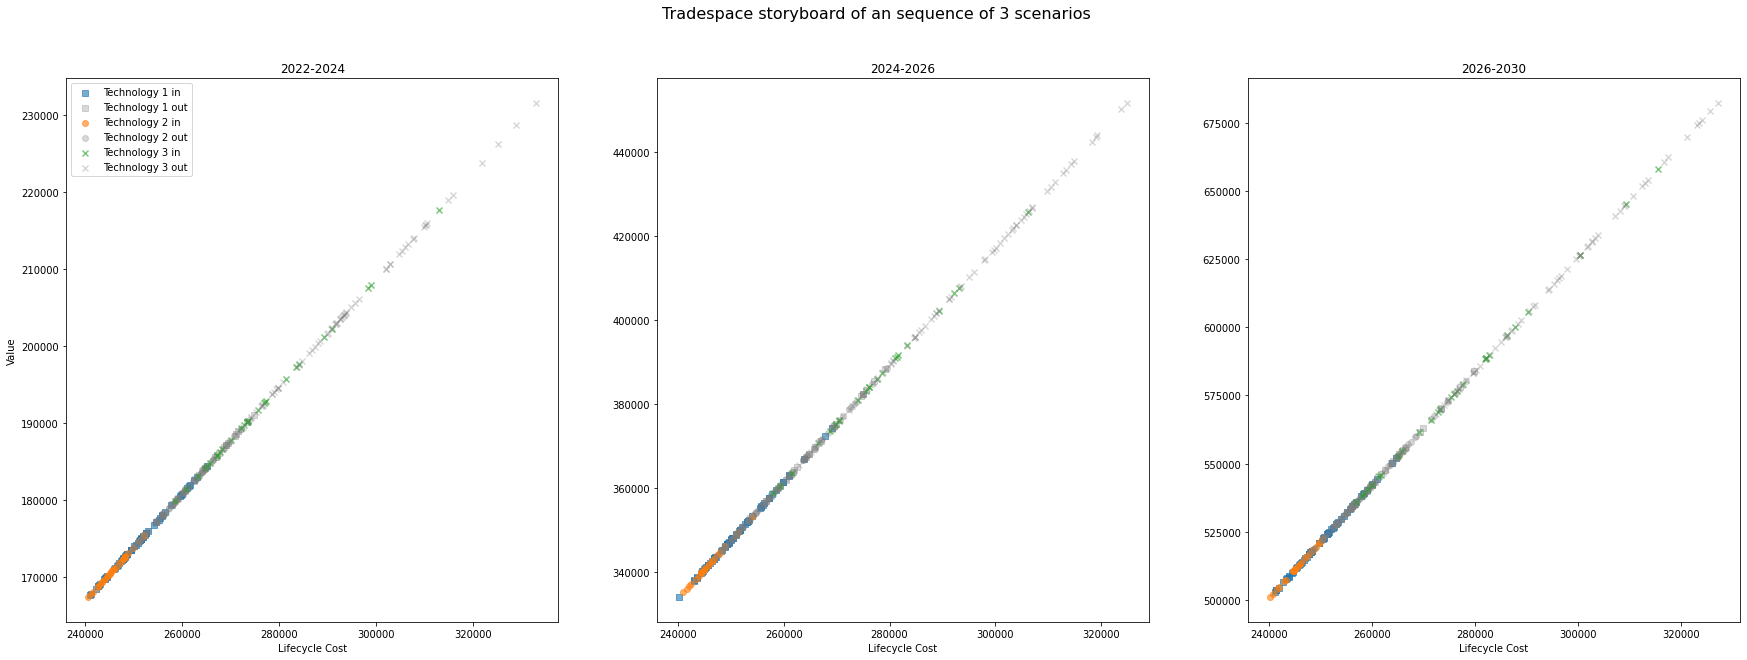

In [12]:
num_samples = 100

platforms = [
    platform(1, 300, 300, 150),
    platform(2, 400, 300, 200),
    platform(3, 300, 300, 300)
]

technologies = [technology(1, 'Technology 1', [1, 3, 1],  {'t_x1':[5,15], 't_x2':[2,6], 't_x3':[1000,5000]}),
                technology(2, 'Technology 2', [1, 3, 2],  {'t_x1':[5,15], 't_x2':[2,6], 't_x3':[5000,20000]}),
                technology(3, 'Technology 3', [1, 3, .5], {'t_x1': [10,20], 't_x2':[4,10], 't_x3':[1000,30000]})
                ]

markers = ['s', 'o', 'x', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd']

fig, epoch_axes = plt.subplots(1, 3, figsize=(30, 10))

fig.suptitle(f"Tradespace storyboard of an sequence of {len(epoch_axes)} scenarios", fontsize=16)

for i, ax in enumerate(epoch_axes):
    #print(f"Epoch {i}")
    for j, tech in enumerate(technologies):
        #print(tech.name)
        x_in, y_in, x_out, y_out = calculate_tradespace_value_cost(tech.factors, num_samples, platforms[2], tech.id)
        ax.scatter(x_in, [element * (i+1) for element in y_in], label=f"Technology {tech.id} in", marker=markers[j], alpha=0.6)
        ax.scatter(x_out, [element * (i+1) for element in y_out], label=f"Technology {tech.id} out", marker=markers[j], color='grey', alpha=0.3)
    if i == 0:
        ax.set_title(f"2022-2024")  # Add a title to the axes.
    elif i == 1:
        ax.set_title(f"2024-2026")  # Add a title to the axes.
    elif i == 2:
        ax.set_title(f"2026-2030")  # Add a title to the axes.
    ax.set_xlabel("Lifecycle Cost")  # Add an x-label to the axes.
    if i == 0: # Only for the first one
        ax.set_ylabel("Value")  # Add a y-label.
        ax.legend();  # Add a legend.
    #else:
    #    epoch_axes[i].sharex(epoch_axes[0])
    #    epoch_axes[i].sharey(epoch_axes[0])

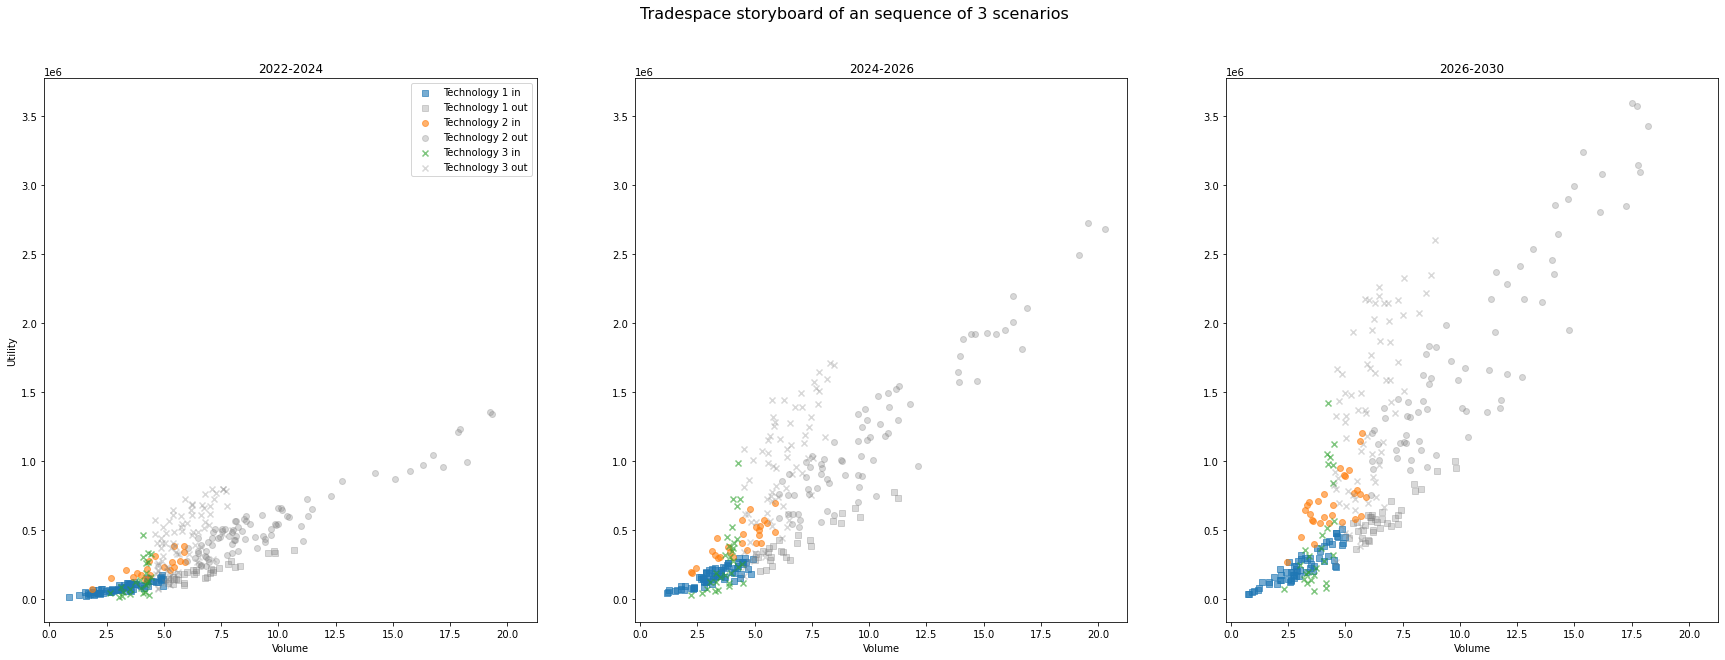

In [13]:
num_samples = 100

platforms = [
    platform(1, 300, 300, 150),
    platform(2, 400, 300, 200),
    platform(3, 300, 300, 300)
]

technologies = [technology(1, 'Technology 1', [1, 3, 1],  {'t_x1':[5,15], 't_x2':[2,6], 't_x3':[1000,5000]}),
                technology(2, 'Technology 2', [1, 3, 2],  {'t_x1':[5,15], 't_x2':[2,6], 't_x3':[5000,20000]}),
                technology(3, 'Technology 3', [1, 3, .5], {'t_x1': [10,20], 't_x2':[4,10], 't_x3':[1000,30000]})
                ]

markers = ['s', 'o', 'x', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd']

fig, epoch_axes = plt.subplots(1, 3, figsize=(30, 10))

fig.suptitle(f"Tradespace storyboard of an sequence of {len(epoch_axes)} scenarios", fontsize=16)

for i, ax in enumerate(epoch_axes):
    #print(f"Epoch {i}")
    for j, tech in enumerate(technologies):
        #print(tech.name)
        x_in, y_in, x_out, y_out = calculate_tradespace(tech.factors, num_samples, platforms[2], tech.id)
        ax.scatter(x_in, [element * (i+1) for element in y_in], label=f"Technology {tech.id} in", marker=markers[j], alpha=0.6)
        ax.scatter(x_out, [element * (i+1) for element in y_out], label=f"Technology {tech.id} out", marker=markers[j], color='grey', alpha=0.3)
    if i == 0:
        ax.set_title(f"2022-2024")
    elif i == 1:
        ax.set_title(f"2024-2026")
    elif i == 2:
        ax.set_title(f"2026-2030")
    ax.set_xlabel("Volume")  # Add an x-label to the axes.
    if i == 0: # Only for the first one
        ax.set_ylabel("Utility")  # Add a y-label.
        ax.legend();  # Add a legend.
    else:
        epoch_axes[i].sharex(epoch_axes[0])
        epoch_axes[i].sharey(epoch_axes[0])

C:\Users\inigo\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California

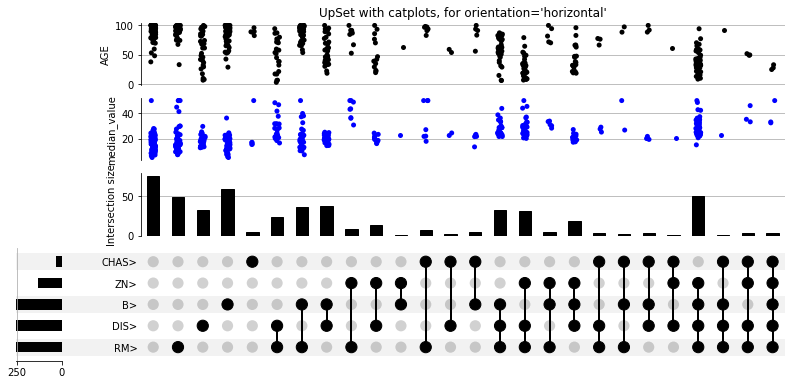

In [17]:
import pandas as pd
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt
from upsetplot import UpSet

# Load the dataset into a DataFrame
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)

# Get five features most correlated with median house value
correls = boston_df.corrwith(pd.Series(boston.target),
                             method='spearman').sort_values()
top_features = correls.index[-5:]

# Get a binary indicator of whether each top feature is above average
boston_above_avg = boston_df > boston_df.median(axis=0)
boston_above_avg = boston_above_avg[top_features]
boston_above_avg = boston_above_avg.rename(columns=lambda x: x + '>')

# Make this indicator mask an index of boston_df
boston_df = pd.concat([boston_df, boston_above_avg],
                      axis=1)
boston_df = boston_df.set_index(list(boston_above_avg.columns))

# Also give us access to the target (median house value)
boston_df = boston_df.assign(median_value=boston.target)
# UpSet plot it!
upset = UpSet(boston_df, subset_size='count', intersection_plot_elements=3)
upset.add_catplot(value='median_value', kind='strip', color='blue')
upset.add_catplot(value='AGE', kind='strip', color='black')
upset.plot()
plt.title("UpSet with catplots, for orientation='horizontal'")
plt.show()

- [ ] Add platform_volume as an input to the design, so the SV simulation can compare it to the volume of the design to determine the cost of redesign (if bigger than the platform volume cost goes up)
- [ ] Do the size check outside the SV simulation, while looping